We continue the idea from 01/25, to use the multiplex sample as the discovery sample, and confirm it in the simplex.

We start with PSEQ and PLINK files:

In [2]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/multiplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and sid not in samples):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 158
Unique families: 20
Unique children: 83


In [3]:
fid = open('/home/sudregp/data/multiplex_simplex/multiplex_kids.txt', 'w')
for k in kids:
    fid.write(k + '\n')
fid.close()

In [1]:
module load plinkseq
module load plink/1.07

cd ~/data/multiplex_simplex/xhmm

pseq DATA new-project
# adding a first column with subject ID for PSEQ
cut -f 2 ../multiplex.ped > junk.txt
paste junk.txt ../multiplex.ped > multiplex.ped.info
pseq DATA load-pedigree --file multiplex.ped.info
pseq DATA load-vcf --vcf DATA.vcf

for q in 50 60 70 80 90; do
    pseq DATA cnv-denovo --noweb --minSQ $q --minNQ $q --out DATA_q${q}
    grep DENOVO DATA_q${q}.denovo.cnv > pseq_DENOVO.txt
    # borrow the header row
    head -1 DATA.xcnv > denovo.xcnv;

    # filter out denovo CNVs
    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_DENOVO.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> denovo.xcnv; 
        done;
    done < ../multiplex_kids.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv denovo.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > denovo_q${q}.cnv
    rm sample.xcnv pseq_DENOVO.txt tmp.cnv denovo.xcnv
    
    # filter out inherited cnvs
    grep MATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv > pseq_TRANSMITTED.txt
    grep PATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv >> pseq_TRANSMITTED.txt
    # borrow the header row
    head -1 DATA.xcnv > inherited.xcnv;

    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_TRANSMITTED.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> inherited.xcnv; 
        done;
    done < ../multiplex_kids.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv inherited.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > inherited_q${q}.cnv
    rm sample.xcnv pseq_TRANSMITTED.txt tmp.cnv inherited.xcnv
    
    # compile all CNVs for kids
    # borrow the header row
    head -1 DATA.xcnv > all.xcnv;

    # effectively just filtering DATA.xcnv to keep only kids
    while read sample; do
        grep $sample DATA.xcnv >> all.xcnv;
    done < ../multiplex_kids.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv all.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > all_q${q}.cnv
    rm tmp.cnv all.xcnv
done

[+] Loading GSL 2.2.1 ...
[+] Loading Graphviz v2.38.0 ...
[+] Loading gdal 2.0 ...
[+] Loading proj 4.9.2 ...
[+] Loading gcc 4.9.1 ...
[+] Loading openmpi 1.10.0 for GCC 4.9.1
[+] Loading tcl_tk 8.6.3
[+] Loading Zlib 1.2.8 ...
[+] Loading Bzip2 1.0.6 ...
[+] Loading pcre 8.38 ...
[+] Loading liblzma 5.2.2 ...
[-] Unloading Zlib 1.2.8 ...
[+] Loading Zlib 1.2.8 ...
[-] Unloading liblzma 5.2.2 ...
[+] Loading liblzma 5.2.2 ...
[+] Loading libjpeg-turbo 1.5.1 ...
[+] Loading tiff 4.0.7 ...
[+] Loading curl 7.46.0 ...
[+] Loading boost libraries v1.65 ...
[+] Loading R 3.4.0 on cn3254
pseq error : VARDB [ /gpfs/gsfs7/users/sudregp/multiplex_simplex/xhmm/DATA_out/vardb ] already exists, delete file first
Inserted 0 new individuals, updated 160 existing individuals
/gpfs/gsfs7/users/sudregp/multiplex_simplex/xhmm/DATA.vcf : inserted 11026 variants

 plinkseq warning: skipping VCF file already loaded into VARDB : /gpfs/gsfs7/users/sudregp/multiplex_simplex/xhmm/DATA.vcf
:::::::::::::::::::

In [3]:
cp ~/data/cnv/penncnv/wellknown_region_hg19 bad_regions.list
cp ~/data/cnv/penncnv/glist-hg19 .
cp ~/data/cnv/penncnv/genes.txt .
cp ~/data/cnv/penncnv/hg19_allenBrainGene_trimmed.txt .

for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        cnvname=${cnvtype}_q${q}.cnv
        plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype}_q${q};
        
        # remove bad regions
        plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
            --cnv-write --out ${cnvtype}_q${q}_clean
        plink --cnv-list ${cnvtype}_q${q}_clean.cnv --cnv-make-map --noweb --1 \
            --out ${cnvtype}_q${q}_clean
        
        for qc in '' '_clean'; do
            cnvname=${cnvtype}_q${q}${qc}.cnv
            # whole burden
            plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-check-no-overlap --out ${cnvtype}_q${q}${qc}_burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --out ${cnvtype}_q${q}${qc}_genes;
            plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt \
                --out ${cnvtype}_q${q}${qc}_brainGenes;
            # subtypes only
            for sub in del dup; do
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-${sub} --out ${cnvtype}_q${q}${qc}_${sub}Burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}Genes;
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}BrainGenes;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50.log ]
Analysis started: Fri Jan 26 17:12:23 2018

Options in effect:
	--cnv-list all_q50.cnv
	--cnv-make-map
	--noweb
	--out all_q50


Reading segment list (CNVs) from [ all_q50.cnv ]
Writing new MAP file to [ all_q50.cnv.map ]
Wrote 12121 unique positions to file

Analysis finished: Fri Jan 26 17:12:23 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|

Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q50_brainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q50.cnv ]
Writing back list to intersected regions to [ all_q50_brainGenes.reg ]
9853 mapped to a person, of which 9853 passed filters
98 intersected with one or more specified region
98 of 9853 mapped as valid segments
 CopyN Case/Control
     1      12 / 28
     3      39 / 19

Writing per-individual summary 

9853 mapped to a person, of which 5279 passed filters
5279 of 9853 mapped as valid segments
 CopyN Case/Control
     3  2957 / 2322

Writing per-individual summary to [ all_q50_dupBurden.cnv.indiv ]
Writing positional summary to [ all_q50_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:14:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_dupGenes.log ]
Analysis started: Fri Jan 26 17:14:57 2018

Options in effect:
	--map all_q50.cnv.map
	--fam ../multiplex_nofam



@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_clean_brainGenes.log ]
Analysis started: Fri Jan 26 17:15:03 2018

Options in effect:
	--map all_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q50_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out all_q50_clean_brainGenes

Reading marker information from [ all_q50_clean.cnv.map ]
457 (of 457) markers to be included from [ all_q

|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_clean_dupBurden.log ]
Analysis started: Fri Jan 26 17:15:03 2018

Options in effect:
	--map all_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q50_clean.cnv
	--noweb
	--1
	--cnv-dup
	--out all_q50_clean_dupBurden

Reading marker information from [ all_q50_clean.cnv.map ]
457 (of 457) markers to be included from [ all_q50_clean.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals

65 kept after excluding specific regions
65 of 1490 mapped as valid segments
 CopyN Case/Control
     1        6 / 5
     3      35 / 19

Writing new CNV list to [ denovo_q50_clean.cnv ]
Writing new FAM file to [ denovo_q50_clean.fam ]

Analysis finished: Fri Jan 26 17:15:25 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_clean.log ]
Analysis started: Fri Jan 26 17:15:25 2018

Options in effect:
	--cnv-list denovo_q50_clean.cnv
	--cnv-make-map
	--noweb
	--1
	--out denov

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q50.cnv ]
1490 mapped to a person, of which 640 passed filters
640 of 1490 mapped as valid segments
 CopyN Case/Control
     1    286 / 354

Writing per-individual summary to [ denovo_q50_delBurden.cnv.indiv ]
Writing positional summary to [ denovo_q50_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:27 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Ski

Writing positional summary to [ denovo_q50_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:29 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_dupBrainGenes.log ]
Analysis started: Fri Jan 26 17:15:29 2018

Options in effect:
	--map denovo_q50.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q50.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out denovo_q50_dupBr


Analysis finished: Fri Jan 26 17:15:29 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_clean_delBurden.log ]
Analysis started: Fri Jan 26 17:15:29 2018

Options in effect:
	--map denovo_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q50_clean.cnv
	--noweb
	--1
	--cnv-del
	--out denovo_q50_clean_delBurden

Reading marker information from [ denovo_q50_clean.cnv.map ]
184 (of 184) markers to be included from [ denovo_q50_clean.cnv.map ]
Reading indiv


Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_clean_dupGenes.log ]
Analysis started: Fri Jan 26 17:15:29 2018

Options in effect:
	--map denovo_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q50_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--out denovo_q50_clean_dupGenes

Reading marker information from [ denovo_q50_clean.cnv.map ]
184 (of 184) markers to be included from [ denovo_q50_clean.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV 

	--cnv-list inherited_q50.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out inherited_q50_burden

Reading marker information from [ inherited_q50.cnv.map ]
1021 (of 1021) markers to be included from [ inherited_q50.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q50.cnv ]
No overlapping samples found
613 mapped to a person, of which 613 passed filters
613 of 613 mapped as valid segments
 CopyN Case/Control
     1    183 / 129
     3    177 / 124

Writing per-individual summary to [ inherited_q50_burden.cnv.indiv ]
Writing positional summary to [ inherited_q50_burden.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:

63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q50.cnv ]
Writing back list to intersected regions to [ inherited_q50_delGenes.reg ]
613 mapped to a person, of which 312 passed filters
261 intersected with one or more specified region
261 of 613 mapped as valid segments
 CopyN Case/Control
     1    154 / 107

Writing per-individual summary to [ inherited_q50_delGenes.cnv.indiv ]
Writing positional summary to [ inherited_q50_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:42 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, 

Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q50_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q50.cnv ]
Writing back list to intersected regions to [ inherited_q50_dupBrainGenes.reg ]
613 mapped to a person, of which 301 passed filters
1 intersected with one or more specified region
1 of 613 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ inherited_q50_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_q50_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:43 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For

1 of 10 mapped as valid segments
 CopyN Case/Control
     1        1 / 0

Writing per-individual summary to [ inherited_q50_clean_delBurden.cnv.indiv ]
Writing positional summary to [ inherited_q50_clean_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:43 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q50_clean_delGenes.log ]
Analysis started: Fri Jan 26 17:15:43 2018

Options in effect:
	--map inherited_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--c

     3        3 / 6

Writing per-individual summary to [ inherited_q50_clean_dupGenes.cnv.indiv ]
Writing positional summary to [ inherited_q50_clean_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:15:44 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q50_clean_dupBrainGenes.log ]
Analysis started: Fri Jan 26 17:15:44 2018

Options in effect:
	--map inherited_q50_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q50_clean.cnv
	--noweb
	--1
	--c

Writing this text to log file [ all_q60_genes.log ]
Analysis started: Fri Jan 26 17:18:06 2018

Options in effect:
	--map all_q60.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q60.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out all_q60_genes

Reading marker information from [ all_q60.cnv.map ]
12121 (of 12121) markers to be included from [ all_q60.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment lis

Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q60_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q60.cnv ]
Writing back list to intersected regions to [ all_q60_delBrainGenes.reg ]
9853 mapped to a person, of which 4574 passed filters
40 intersected with one or more specified region
40 of 9853 mapped as valid segments
 CopyN Case/Control
     1      12 / 28

Writing per-individual summary to [ all_q60_d


Reading segment list (CNVs) from [ all_q60_clean.cnv ]
No overlapping samples found
196 mapped to a person, of which 196 passed filters
196 of 196 mapped as valid segments
 CopyN Case/Control
     1      32 / 27
     3      89 / 48

Writing per-individual summary to [ all_q60_clean_burden.cnv.indiv ]
Writing positional summary to [ all_q60_clean_burden.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:26 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q60_clean_genes.log ]
A

Writing positional summary to [ all_q60_clean_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:27 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q60_clean_delBrainGenes.log ]
Analysis started: Fri Jan 26 17:18:27 2018

Options in effect:
	--map all_q60_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q60_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	--out all_



@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60.log ]
Analysis started: Fri Jan 26 17:18:27 2018

Options in effect:
	--cnv-list denovo_q60.cnv
	--cnv-make-map
	--noweb
	--out denovo_q60


Reading segment list (CNVs) from [ denovo_q60.cnv ]
Writing new MAP file to [ denovo_q60.cnv.map ]
Wrote 2257 unique positions to file

Analysis finished: Fri Jan 26 17:18:27 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/A


Reading marker information from [ denovo_q60.cnv.map ]
2257 (of 2257) markers to be included from [ denovo_q60.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q60_brainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q60.cnv ]
Writing back list to intersected regions to [ denovo_q60_brainGenes.reg ]
923 mapped to a person, of which 923 passed filters
16 intersected with one or more specified region

160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q60.cnv ]
923 mapped to a person, of which 519 passed filters
519 of 923 mapped as valid segments
 CopyN Case/Control
     3    314 / 205

Writing per-individual summary to [ denovo_q60_dupBurden.cnv.indiv ]
Writing positional summary to [ denovo_q60_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:43 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@-----------------------

40 intersected with one or more specified region
40 of 41 mapped as valid segments
 CopyN Case/Control
     1        5 / 2
     3      18 / 15

Writing per-individual summary to [ denovo_q60_clean_genes.cnv.indiv ]
Writing positional summary to [ denovo_q60_clean_genes.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:44 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60_clean_brainGenes.log ]
Analysis started: Fri Jan 26 17:18:44 2018

Options in effect:
	--map denovo_q6

0 of 41 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_q60_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q60_clean_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:44 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60_clean_dupBurden.log ]
Analysis started: Fri Jan 26 17:18:44 2018

Options in effect:
	--map denovo_q60_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q60_clea

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading CNV intersection list from [ bad_regions.list ]
Read 380994 ranges to exclude from CNV list

Reading segment list (CNVs) from [ inherited_q60.cnv ]
527 mapped to a person, of which 527 passed filters
9 kept after excluding specific regions
9 of 527 mapped as valid segments
 CopyN Case/Control
     1        1 / 0
     3        3 / 5

Writing new CNV list to [ inherited_q60_clean.cnv ]
Writing new FAM file to [ inherited_q60_clean.fam ]

Analysis finished: Fri Jan 26 17:18:54 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|---------------------

Analysis started: Fri Jan 26 17:18:55 2018

Options in effect:
	--map inherited_q60.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q60.cnv
	--noweb
	--1
	--cnv-del
	--out inherited_q60_delBurden

Reading marker information from [ inherited_q60.cnv.map ]
887 (of 887) markers to be included from [ inherited_q60.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q60.cnv ]
527 mapped to a person, of which 261 passed filters
261 of 527 mapped as valid segments
 CopyN Case/Control
     1    157 / 104

Writing per-individual summary to [ inherited_q60_delBurden.cnv.indiv ]
Writing positional summary to [ inheri

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q60.cnv ]
Writing back list to intersected regions to [ inherited_q60_dupGenes.reg ]
527 mapped to a person, of which 266 passed filters
217 intersected with one or more specified region
217 of 527 mapped as valid segments
 CopyN Case/Control
     3     131 / 86

Writing per-individual summary to [ inherited_q60_dupGenes.cnv.indiv ]
Writing positional summary to [ inherited_q60_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:56 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|---------------------------------------------------------

63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q60_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q60_clean.cnv ]
Writing back list to intersected regions to [ inherited_q60_clean_brainGenes.reg ]
9 mapped to a person, of which 9 passed filters
0 intersected with one or more specified region
0 of 9 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q60_clean_brainGenes.cnv.indiv ]
Writing positional summary to [ inherited_q60_clean_brainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|------

83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q60_clean.cnv ]
9 mapped to a person, of which 8 passed filters
8 of 9 mapped as valid segments
 CopyN Case/Control
     3        3 / 5

Writing per-individual summary to [ inherited_q60_clean_dupBurden.cnv.indiv ]
Writing positional summary to [ inherited_q60_clean_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:18:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q60

Writing new MAP file to [ all_q70_clean.cnv.map ]
Wrote 457 unique positions to file

Analysis finished: Fri Jan 26 17:21:20 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q70_burden.log ]
Analysis started: Fri Jan 26 17:21:20 2018

Options in effect:
	--map all_q70.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q70.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out all_q70_burden

Reading marker information from [ all_q70.cnv.map ]
12121 (of 12121) markers to be inclu

	--fam ../multiplex_nofamid.ped
	--cnv-list all_q70.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out all_q70_delGenes

Reading marker information from [ all_q70.cnv.map ]
12121 (of 12121) markers to be included from [ all_q70.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q70.cnv ]
Writing back list to intersected regions to [ all_q70_delGenes.reg ]
9853 mapped to a person, 

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q70_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q70.cnv ]
Writing back list to intersected regions to [ all_q70_dupBrainGenes.reg ]
9853 mapped to a person, of which 5279 passed filters
58 intersected with one or more specified region
58 of 9853 mapped as valid segments
 CopyN Case/Control
     3      39 / 19

Writing per-individual summary to [ all_q70_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ all_q70_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:21

83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ all_q70_clean.cnv ]
196 mapped to a person, of which 59 passed filters
59 of 196 mapped as valid segments
 CopyN Case/Control
     1      32 / 27

Writing per-individual summary to [ all_q70_clean_delBurden.cnv.indiv ]
Writing positional summary to [ all_q70_clean_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:21:40 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q70_clean_delGenes.lo

Writing positional summary to [ all_q70_clean_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:21:40 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q70_clean_dupBrainGenes.log ]
Analysis started: Fri Jan 26 17:21:40 2018

Options in effect:
	--map all_q70_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q70_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out all_

Analysis started: Fri Jan 26 17:21:49 2018

Options in effect:
	--map denovo_q70.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q70.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out denovo_q70_genes

Reading marker information from [ denovo_q70.cnv.map ]
1348 (of 1348) markers to be included from [ denovo_q70.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q70.cnv ]
Writin

1348 (of 1348) markers to be included from [ denovo_q70.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q70_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q70.cnv ]
Writing back list to intersected regions to [ denovo_q70_delBrainGenes.reg ]
526 mapped to a person, of which 223 passed filters
2 intersected with one or more specified region
2 of 526 mapped as valid segments
 CopyN Case/Cont

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q70_clean.cnv ]
No overlapping samples found
22 mapped to a person, of which 22 passed filters
22 of 22 mapped as valid segments
 CopyN Case/Control
     1        1 / 1
     3       11 / 9

Writing per-individual summary to [ denovo_q70_clean_burden.cnv.indiv ]
Writing positional summary to [ denovo_q70_clean_burden.cnv.summary ]

Analysis finished: Fri Jan 26 17:21:51 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@---------

22 mapped to a person, of which 2 passed filters
2 intersected with one or more specified region
2 of 22 mapped as valid segments
 CopyN Case/Control
     1        1 / 1

Writing per-individual summary to [ denovo_q70_clean_delGenes.cnv.indiv ]
Writing positional summary to [ denovo_q70_clean_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:21:51 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q70_clean_delBrainGenes.log ]
Analysis started: Fri Jan 26 17:21:51 2018


2 intersected with one or more specified region
2 of 22 mapped as valid segments
 CopyN Case/Control
     3        1 / 1

Writing per-individual summary to [ denovo_q70_clean_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q70_clean_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:21:52 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q70.log ]
Analysis started: Fri Jan 26 17:21:52 2018

Options in effect:
	--cnv-list inherited_q70.cnv
	--cnv


Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q70_brainGenes.log ]
Analysis started: Fri Jan 26 17:22:01 2018

Options in effect:
	--map inherited_q70.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q70.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out inherited_q70_brainGenes

Reading marker information from [ inherited_q70.cnv.map ]
735 (of 735) markers to be included from [ inherited_q70.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ra

Analysis started: Fri Jan 26 17:22:01 2018

Options in effect:
	--map inherited_q70.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q70.cnv
	--noweb
	--1
	--cnv-dup
	--out inherited_q70_dupBurden

Reading marker information from [ inherited_q70.cnv.map ]
735 (of 735) markers to be included from [ inherited_q70.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q70.cnv ]
424 mapped to a person, of which 212 passed filters
212 of 424 mapped as valid segments
 CopyN Case/Control
     3     128 / 84

Writing per-individual summary to [ inherited_q70_dupBurden.cnv.indiv ]
Writing positional summary to [ inheri

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q70_clean.cnv ]
Writing back list to intersected regions to [ inherited_q70_clean_genes.reg ]
6 mapped to a person, of which 6 passed filters
6 intersected with one or more specified region
6 of 6 mapped as valid segments
 CopyN Case/Control
     1        1 / 0
     3        3 / 2

Writing per-individual summary to [ inherited_q70_clean_genes.cnv.indiv ]
Writing positional summary to [ inherited_q70_clean_genes.cnv.summary ]

Analysis finished: Fri Jan 26 17:22:02 2018


@-------------------------------------------------------

160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q70_clean_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q70_clean.cnv ]
Writing back list to intersected regions to [ inherited_q70_clean_delBrainGenes.reg ]
6 mapped to a person, of which 1 passed filters
0 intersected with one or more specified region
0 of 6 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q70_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_q70_clean_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:22:02 2018


@---------------

|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_clean.log ]
Analysis started: Fri Jan 26 17:22:03 2018

Options in effect:
	--map all_q80.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q80.cnv
	--noweb
	--1
	--cnv-exclude bad_regions.list
	--cnv-overlap .5
	--cnv-write
	--out all_q80_clean

Reading marker information from [ all_q80.cnv.map ]
12121 (of 12121) markers to be included from [ all_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Re

|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_delBurden.log ]
Analysis started: Fri Jan 26 17:24:35 2018

Options in effect:
	--map all_q80.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q80.cnv
	--noweb
	--1
	--cnv-del
	--out all_q80_delBurden

Reading marker information from [ all_q80.cnv.map ]
12121 (of 12121) markers to be included from [ all_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_n

12121 (of 12121) markers to be included from [ all_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q80.cnv ]
Writing back list to intersected regions to [ all_q80_dupGenes.reg ]
9853 mapped to a person, of which 5279 passed filters
4696 intersected with one or more specified region
4696 of 9853 mapped as valid segments
 CopyN Case/Control
     3  2651 / 2045

Writing per-individual summary to [ all_q80_dupGenes.cnv.indiv ]
Writing position

160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q80_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q80_clean.cnv ]
Writing back list to intersected regions to [ all_q80_clean_brainGenes.reg ]
196 mapped to a person, of which 196 passed filters
7 intersected with one or more specified region
7 of 196 mapped as valid segments
 CopyN Case/Control
     1        1 / 0
     3        4 / 2

Writing per-individual summary to [ all_q80_clean_brainGenes.cnv.indiv ]
Writing positional summary to [ all_q80_clean_brainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:24:46 2018


@-----------

196 mapped to a person, of which 137 passed filters
137 of 196 mapped as valid segments
 CopyN Case/Control
     3      89 / 48

Writing per-individual summary to [ all_q80_clean_dupBurden.cnv.indiv ]
Writing positional summary to [ all_q80_clean_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:24:46 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_clean_dupGenes.log ]
Analysis started: Fri Jan 26 17:24:46 2018

Options in effect:
	--map all_q80_clean.cnv.map
	--fa

|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q80_burden.log ]
Analysis started: Fri Jan 26 17:24:51 2018

Options in effect:
	--map denovo_q80.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q80.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out denovo_q80_burden

Reading marker information from [ denovo_q80.cnv.map ]
593 (of 593) markers to be included from [ denovo_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read 

	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out denovo_q80_delGenes

Reading marker information from [ denovo_q80.cnv.map ]
593 (of 593) markers to be included from [ denovo_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q80.cnv ]
Writing back list to intersected regions to [ denovo_q80_delGenes.reg ]
223 mapped to a person, of which 87 passed filters
73 intersected with one or more specified region
73 of 223 ma

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q80_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q80.cnv ]
Writing back list to intersected regions to [ denovo_q80_dupBrainGenes.reg ]
223 mapped to a person, of which 136 passed filters
2 intersected with one or more specified region
2 of 223 mapped as valid segments
 CopyN Case/Control
     3        2 / 0

Writing per-individual summary to [ denovo_q80_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q80_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Ja

83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q80_clean.cnv ]
3 mapped to a person, of which 0 passed filters
0 of 3 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_q80_clean_delBurden.cnv.indiv ]
Writing positional summary to [ denovo_q80_clean_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:24:53 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q80_clean_delGenes.log ]
Analysis s


Writing per-individual summary to [ denovo_q80_clean_dupGenes.cnv.indiv ]
Writing positional summary to [ denovo_q80_clean_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:24:53 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q80_clean_dupBrainGenes.log ]
Analysis started: Fri Jan 26 17:24:53 2018

Options in effect:
	--map denovo_q80_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q80_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verb

@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q80_genes.log ]
Analysis started: Fri Jan 26 17:25:00 2018

Options in effect:
	--map inherited_q80.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q80.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out inherited_q80_genes

Reading marker information from [ inherited_q80.cnv.map ]
570 (of 570) markers to be included from [ inherited_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of

	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q80.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	--out inherited_q80_delBrainGenes

Reading marker information from [ inherited_q80.cnv.map ]
570 (of 570) markers to be included from [ inherited_q80.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q80_delBrainGenes.not

	--1
	--cnv-check-no-overlap
	--out inherited_q80_clean_burden

Reading marker information from [ inherited_q80_clean.cnv.map ]
12 (of 12) markers to be included from [ inherited_q80_clean.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q80_clean.cnv ]
No overlapping samples found
5 mapped to a person, of which 5 passed filters
5 of 5 mapped as valid segments
 CopyN Case/Control
     1        1 / 0
     3        3 / 1

Writing per-individual summary to [ inherited_q80_clean_burden.cnv.indiv ]
Writing positional summary to [ inherited_q80_clean_burden.cnv.summary ]

Analysis finished: Fri Jan 26 17:25:01 2018


@----

160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q80_clean.cnv ]
Writing back list to intersected regions to [ inherited_q80_clean_delGenes.reg ]
5 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 5 mapped as valid segments
 CopyN Case/Control
     1        1 / 0

Writing per-individual summary to [ inherited_q80_clean_delGenes.cnv.indiv ]
Writing positional summary to [ inherited_q80_clean_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:25:02 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q80_clean_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q80_clean.cnv ]
Writing back list to intersected regions to [ inherited_q80_clean_dupBrainGenes.reg ]
5 mapped to a person, of which 4 passed filters
0 intersected with one or more specified region
0 of 5 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q80_clean_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_q80_clean_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:25:02 2018


@----------------------------------------------------------

|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q90_brainGenes.log ]
Analysis started: Fri Jan 26 17:27:34 2018

Options in effect:
	--map all_q90.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q90.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out all_q90_brainGenes

Reading marker information from [ all_q90.cnv.map ]
12121 (of 12121) markers to be included from [ all_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading ped

|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q90_dupBurden.log ]
Analysis started: Fri Jan 26 17:27:39 2018

Options in effect:
	--map all_q90.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q90.cnv
	--noweb
	--1
	--cnv-dup
	--out all_q90_dupBurden

Reading marker information from [ all_q90.cnv.map ]
12121 (of 12121) markers to be included from [ all_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ all_q90.cnv ]
9853 mapped to a person, of which 5279 passed filters
527

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q90_clean.cnv ]
Writing back list to intersected regions to [ all_q90_clean_genes.reg ]
196 mapped to a person, of which 196 passed filters
194 intersected with one or more specified region
194 of 196 mapped as valid segments
 CopyN Case/Control
     1      32 / 26
     3      89 / 47

Writing per-individual summary to [ all_q90_clean_genes.cnv.indiv ]
Writing positional summary to [ all_q90_clean_genes.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:45 2018


@----------------------------------------------------------@
|        

Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q90_clean_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q90_clean.cnv ]
Writing back list to intersected regions to [ all_q90_clean_delBrainGenes.reg ]
196 mapped to a person, of which 59 passed filters
1 intersected with one or more specified region
1 of 196 mapped as valid segments
 CopyN Case/Control
     1        1 / 0

Writing per-individual summary to [ all_q90_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ all_q90_clean_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:46 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purc


Options in effect:
	--map denovo_q90.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q90.cnv
	--noweb
	--1
	--cnv-exclude bad_regions.list
	--cnv-overlap .5
	--cnv-write
	--out denovo_q90_clean

Reading marker information from [ denovo_q90.cnv.map ]
160 (of 160) markers to be included from [ denovo_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading CNV intersection list from [ bad_regions.list ]
Read 380994 ranges to exclude from CNV list

Reading segment list (CNVs) from [ denovo_q90.cnv ]
57 mapped to a person, of which 57 passed filters
1 kept after excluding specific regions
1 of 57 mapped as valid segments
 CopyN Case/Control
     3   

|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q90_delBurden.log ]
Analysis started: Fri Jan 26 17:27:49 2018

Options in effect:
	--map denovo_q90.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q90.cnv
	--noweb
	--1
	--cnv-del
	--out denovo_q90_delBurden

Reading marker information from [ denovo_q90.cnv.map ]
160 (of 160) markers to be included from [ denovo_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) fro

160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q90.cnv ]
Writing back list to intersected regions to [ denovo_q90_dupGenes.reg ]
57 mapped to a person, of which 39 passed filters
37 intersected with one or more specified region
37 of 57 mapped as valid segments
 CopyN Case/Control
     3       30 / 7

Writing per-individual summary to [ denovo_q90_dupGenes.cnv.indiv ]
Writing positional summary to [ denovo_q90_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:50 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07    

Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q90_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q90_clean.cnv ]
Writing back list to intersected regions to [ denovo_q90_clean_brainGenes.reg ]
1 mapped to a person, of which 1 passed filters
0 intersected with one or more specified region
0 of 1 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_q90_clean_brainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q90_clean_brainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:50 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Publi

Writing positional summary to [ denovo_q90_clean_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:51 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q90_clean_dupGenes.log ]
Analysis started: Fri Jan 26 17:27:51 2018

Options in effect:
	--map denovo_q90_clean.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list denovo_q90_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--out denovo_q90_clean_d

|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q90_burden.log ]
Analysis started: Fri Jan 26 17:27:55 2018

Options in effect:
	--map inherited_q90.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list inherited_q90.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out inherited_q90_burden

Reading marker information from [ inherited_q90.cnv.map ]
279 (of 279) markers to be included from [ inherited_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenoty

	--cnv-subset genes.txt
	--cnv-del
	--out inherited_q90_delGenes

Reading marker information from [ inherited_q90.cnv.map ]
279 (of 279) markers to be included from [ inherited_q90.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q90.cnv ]
Writing back list to intersected regions to [ inherited_q90_delGenes.reg ]
143 mapped to a person, of which 71 passed filters
65 intersected with one or more specified region
65 of 143 mapped as valid s

Reading pedigree information from [ ../multiplex_nofamid.ped ] 
160 individuals read from [ ../multiplex_nofamid.ped ] 
160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q90_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q90.cnv ]
Writing back list to intersected regions to [ inherited_q90_dupBrainGenes.reg ]
143 mapped to a person, of which 72 passed filters
0 intersected with one or more specified region
0 of 143 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q90_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_

160 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
63 cases, 97 controls and 0 missing
83 males, 77 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q90_clean.cnv ]
1 mapped to a person, of which 0 passed filters
0 of 1 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q90_clean_delBurden.cnv.indiv ]
Writing positional summary to [ inherited_q90_clean_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@------------------------

Writing back list to intersected regions to [ inherited_q90_clean_dupGenes.reg ]
1 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 1 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ inherited_q90_clean_dupGenes.cnv.indiv ]
Writing positional summary to [ inherited_q90_clean_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 17:27:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log fi

Picture time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

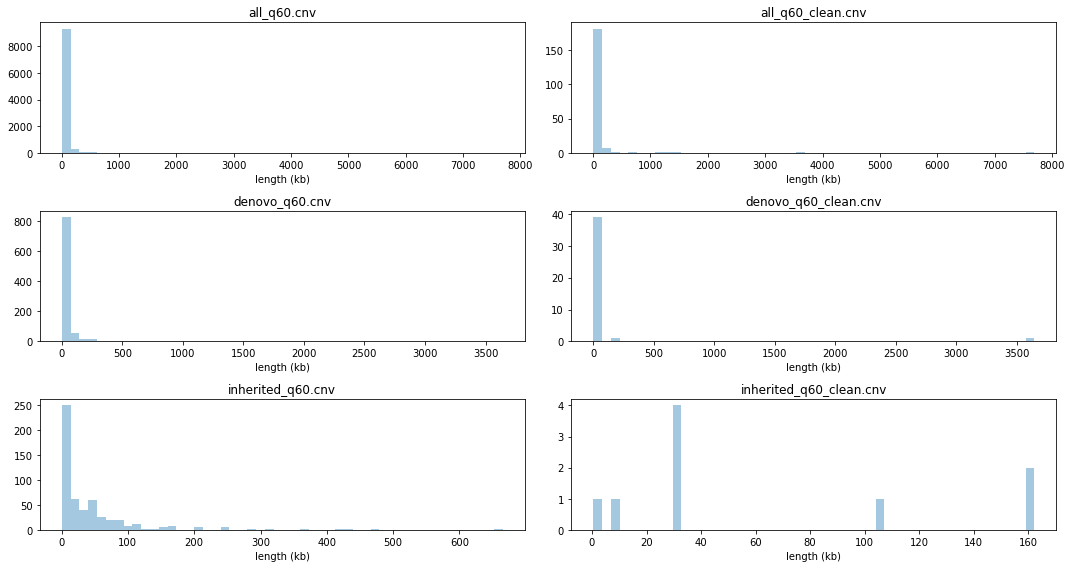

In [2]:
data_dir = '/home/sudregp/data/multiplex_simplex/xhmm/'
files = glob.glob(data_dir + '/*_q60*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

It looks like this time we might have a bit more in the 500 range. Maybe let's add 100 to the mix.

In [3]:
%%bash

module load plink/1.07

cd ~/data/multiplex_simplex/xhmm
for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        for qc in '' '_clean'; do
            for kb in 250 500 1000; do
                cnvname=${cnvtype}_q${q}${qc}.cnv
                # whole burden
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-check-no-overlap --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_genes;
                plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_brainGenes;
                # subtypes only
                for sub in del dup; do
                    plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-${sub} --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Burden;
                    # gene sets
                    plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset genes.txt --cnv-${sub} --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Genes;
                    plink --map ${cnvname}.map --fam ../multiplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                        --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}BrainGenes;
                done;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_lenLT250_burden.log ]
Analysis started: Fri Jan 26 18:07:33 2018

Options in effect:
	--map all_q50.cnv.map
	--fam ../multiplex_nofamid.ped
	--cnv-list all_q50.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--cnv-max-kb 250
	--out all_q50_lenLT250_burden

Reading marker information from [ all_q50.cnv.map ]
12121 (of 12121) markers to be included from [ all_q50.cnv.map ]
Reading individual information from [ ../multiplex_nofamid.ped ]
R

The scatterplots won't work well here because many families only have one kid. We need to either to the heatmaps or just do the gene-based analyis.

In [12]:
fid = open('/home/sudregp/data/multiplex_simplex/xhmm/denovo_q60_clean_lenLT250_genes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
ZBTB33,3
HMGN5,2
MAGEA6,2
PHF6,2
RBMX,2
REV3L,2
CDR1,2
CYLC1,1
ZNF780A,1
AGO1,1


In [13]:
dfs = df.sort_values(by='count', ascending=False).head(7)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/multiplex_simplex/xhmm/denovo_q60_clean_lenLT250_genes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ X 119384606 119392251 ZBTB33 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1        WPS_16        1   23    119389459    119390636    DUP    1.177        1   0.1541   0.1541
   1        WPS_26        1   23    119390012    119392282    DUP     2.27   0.9863   0.2918    0.293
   1        WPS_25        2   23    119390549    119392282    DEL    1.733   0.9821   0.2218   0.2227
RANGE (+/- 0kb )  [ X 80369199 80457441 HMGN5 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400049        1   23     80369944     80371866    DEL    1.922        1  0.02179  0.02179
   1   CCGO_800980        2   23     80370293     80370787    DEL    0.494        1  0.00561  0.00561
RANGE (+/- 0kb )  [ X 151867244 151870814 MAGEA6 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CCGO_800734        2   23  

Not so hot.. maybe other filtering schemes?